In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('F:/Linux')
# sys.path.append("C:/Users/qq651/OneDrive/Codes/A2project/")
import illustris_python as il
import matplotlib.pyplot as plt
# from plotTools.plot import *

def Flatness(MassTensor):
    if MassTensor is int:
        return 0
    #c / a = (M3)**0.5 / (M1)**0.5
    return np.sqrt(MassTensor[0]) / np.sqrt(MassTensor[2])

def BtoA(MassTensor):
    if MassTensor is int:
        return 0
    #b / a = (M2)**0.5 / (M1)**0.5
    return np.sqrt(MassTensor[0]) / np.sqrt(MassTensor[1])

def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if simu == 'TNG':
        ldir = 'f:/Linux/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = 'f:/Linux/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def MassTensorEigenVals(coor, mas, half_r):
    '''
    Return eigenvalues of the mass tensor, sorted by M1 < M2 < M3
    '''
    r = coor - coor[0]
    r[r > 37500] -= 75000
    r[r < -37500] += 75000
    dis = np.linalg.norm(r, axis=1)
    inside = dis < (half_r * 2)
    r = r[inside]
    mas = mas[inside]

    M_x = ((mas * (r[:, 0]/0.6774)**2).sum())**0.5 / mas.sum()**0.5
    M_y = ((mas * (r[:, 1]/0.6774)**2).sum())**0.5 / mas.sum()**0.5
    M_z = ((mas * (r[:, 2]/0.6774)**2).sum())**0.5 / mas.sum()**0.5
    M = np.array([M_x, M_y, M_z])
    M.sort()
    return M

def ErrorBarMedian(data):
    #return 25%, 50%, 75%
    if len(data) == 0:
        return 0, 0, 0
    elif len(data) < 3:
        return 0, np.median(data), 0
    else:
        data.sort()
        return data[int(len(data) / 4)], np.median(data), data[int(len(data) * 0.75)]

In [2]:
#This function is special, not use the plot.Y_rawdata in this file
def Y_rawdata(data, snapnum):
    plotdata = [[], [], []]
    for i in range(snapnum):
        d0, d1, d2 = ErrorBarMedian(data[:, i])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1, :], Err

In [3]:
# path_99 = 'f:/Linux/data/TNG/cutoff/disk_99'
il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy', allow_pickle=1)
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy', allow_pickle=1)
il1_MTE = np.load('f:/Linux/localRUN/MTE_il1.npy', allow_pickle=1).item()

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy', allow_pickle=1)
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy', allow_pickle=1)
tng_MTE = np.load('f:/Linux/localRUN/MTE_TNGdisk_4WP.npy', allow_pickle=1).item()
tng_A2list = np.load('f:/Linux/localRUN/TNG_A2withRedshift.npy', allow_pickle=1).item()
'''
Illustris-1 Snapshot-Redshift:
snap_127 z=0.1
snap_120 z=0.2
snap_113 z=0.3
snap_108 z=0.4
snap_103 z=0.5
snap_95 z=0.7
snap_85 z=1.0
snap_75 z=1.5
snap_68 z=2.0

SnapList = [135, 127, 120, 113, 108, 103, 95, 85, 75, 68]
RedShift = [0, 0.1 , 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0]

TNG Snapshot-Redshift:
snap_91 z=0.1
snap_84 z=0.2
snap_78 z=0.3
snap_72 z=0.4
snap_67 z=0.5
snap_59 z=0.7
snap_50 z=1.0
snap_40 z=1.5
snap_33 z=2.0
'''

il1_snapshot = [135, 127, 120, 113, 103, 108, 95, 85, 75, 68]
tng_snapshot = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33]

RedShift = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0]
RedShift = np.array(RedShift)

dolist = [0, 2, 5, 6, 7, 8, 9]
rs = RedShift[dolist]

In [4]:
tng_nobar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_nobar.append(i)

il1_nobar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_nobar.append(i)

In [5]:
count=0
for haloID in il1_diskID:
    mte = il1_MTE[haloID]
    for i in range(10):
        if type(mte[i]) is int:
            count+=1
print(count)

17


In [6]:
tng_ca_bar = []
tng_ba_bar = []
tng_ca_nobar = []
tng_ba_nobar = []

for haloID in tng_diskID:
    mte = tng_MTE[haloID]
    ca = []
    ba = []
    isdata = True
    for i in dolist:
        if type(mte[i]) is int:
            isdata = False
            break
        ca.append(Flatness(mte[i]))
        ba.append(BtoA(mte[i]))

    if isdata:
        if haloID in tng_barID:
            tng_ca_bar.append(ca)
            tng_ba_bar.append(ba)
        else:
            tng_ca_nobar.append(ca)
            tng_ba_nobar.append(ba)
            
tng_ca_bar = np.array(tng_ca_bar)
tng_ba_bar = np.array(tng_ba_bar)
tng_ca_nobar = np.array(tng_ca_nobar)
tng_ba_nobar = np.array(tng_ba_nobar)

In [8]:
il1_ca_bar = []
il1_ba_bar = []
il1_ca_nobar = []
il1_ba_nobar = []

count = 0
b = 0
nb= 0
for haloID in il1_diskID:
    mte = il1_MTE[haloID]
    ca = []
    ba = []
    isdata = True
    for i in dolist:
        if type(mte[i]) is int:
            isdata = False
            break
        ca.append(Flatness(mte[i]))
        ba.append(BtoA(mte[i]))

    if isdata:
        count+=1
        if haloID in il1_barID:
            b+=1
            il1_ca_bar.append(ca)
            il1_ba_bar.append(ba)
        else:
            nb+=1
            il1_ca_nobar.append(ca)
            il1_ba_nobar.append(ba)

il1_ba_bar = np.array(il1_ba_bar)
il1_ca_bar = np.array(il1_ca_bar)
il1_ba_nobar = np.array(il1_ba_nobar)
il1_ca_nobar = np.array(il1_ca_nobar)

print(b,nb)

110 1116


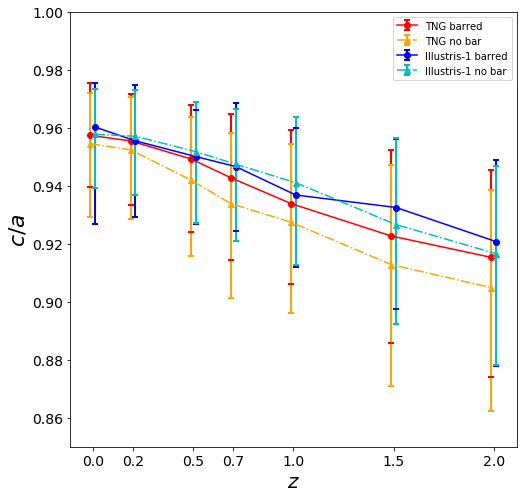

In [9]:
tng_ca_Y_bar, tng_b_err = Y_rawdata(tng_ca_bar, len(rs))
tng_ca_Y_nobar, tng_nb_err = Y_rawdata(tng_ca_nobar, len(rs))
il1_ca_Y_bar, il1_b_err = Y_rawdata(il1_ca_bar, len(rs))
il1_ca_Y_nobar, il1_nb_err = Y_rawdata(il1_ca_nobar, len(rs))

plt.figure(figsize=(8,8))
plt.errorbar(rs-0.012, tng_ca_Y_bar, yerr=tng_b_err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', ls='-', label='TNG barred')
plt.errorbar(rs-0.012, tng_ca_Y_nobar, yerr=tng_nb_err, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^', ls='-.', label='TNG no bar')

plt.errorbar(rs+0.012, il1_ca_Y_bar, yerr=il1_b_err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ls='-', label='Illustris-1 barred')
plt.errorbar(rs+0.012, il1_ca_Y_nobar, yerr=il1_nb_err, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ls='-.', label='Illustris-1 no bar')
plt.ylim(0.85, 1)

plt.xticks(rs)
plt.xlabel('$z$', fontsize=20)
plt.ylabel('$c/a$', fontsize=22)
plt.tick_params(labelsize=14)
plt.legend()
plt.savefig('f:/Linux/local_result/AxisRatio/CA_err.pdf')

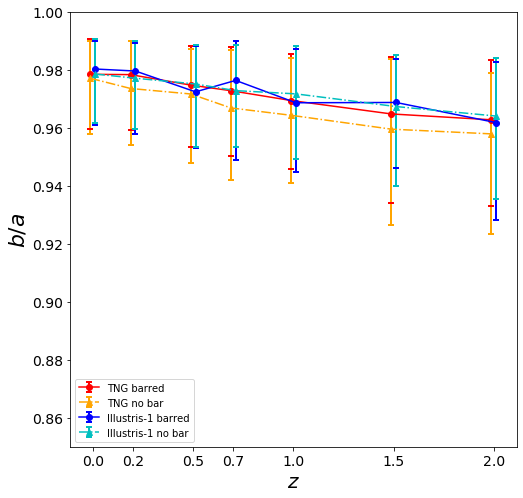

In [10]:
tng_ba_Y_bar, tng_b_err = Y_rawdata(tng_ba_bar, len(rs))
tng_ba_Y_nobar, tng_nb_err = Y_rawdata(tng_ba_nobar, len(rs))
il1_ba_Y_bar, il1_b_err = Y_rawdata(il1_ba_bar, len(rs))
il1_ba_Y_nobar, il1_nb_err = Y_rawdata(il1_ba_nobar, len(rs))

plt.figure(figsize=(8,8))
plt.errorbar(rs-0.012, tng_ba_Y_bar, yerr=tng_b_err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', ls='-', label='TNG barred')
plt.errorbar(rs-0.012, tng_ba_Y_nobar, yerr=tng_nb_err, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^', ls='-.', label='TNG no bar')

plt.errorbar(rs+0.012, il1_ba_Y_bar, yerr=il1_b_err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ls='-', label='Illustris-1 barred')
plt.errorbar(rs+0.012, il1_ba_Y_nobar, yerr=il1_nb_err, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ls='-.', label='Illustris-1 no bar')
plt.ylim(0.85, 1)

plt.xticks(RedShift[dolist])
plt.xlabel('$z$', fontsize=20)
plt.ylabel('$b/a$', fontsize=22)
plt.tick_params(labelsize=14)
plt.legend()
plt.savefig('f:/Linux/local_result/AxisRatio/BA_err.pdf')